In [52]:
import pandas as pd
import arviz as az
import numpy as np
from utils import *
import warnings
warnings.filterwarnings('ignore')
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt

def prepare_test_data(mus, sigmas, n=100):

    # Set the random seed for reproducibility
    np.random.seed(123)

    # Generate random values for three clusters
    cluster1 = np.random.normal(loc=mus[0], scale=sigmas[0], size=n)
    cluster2 = np.random.normal(loc=mus[1], scale=sigmas[1], size=n)
    cluster3 = np.random.normal(loc=mus[2], scale=sigmas[2], size=n)

    # Combine the clusters into a single array
    data = np.concatenate([cluster1, cluster2, cluster3])

    # Create the DataFrame
    df = pd.DataFrame(data, columns=['Value'])
    return df

In [ ]:
df = prepare_test_data(mus=[10, 20, 5], sigmas=[3, 3, 3])

In [129]:
df = get_data(
    'AAPL', 
    '2023-05-29', '2023-06-02')

[*********************100%***********************]  1 of 1 completed


In [130]:
df = get_returns(df)

In [131]:
df['moving_average'] = df['returns'].rolling(10, closed='left').mean()

In [132]:
df.fillna(0, inplace=True)

In [133]:
df = df[['returns', 'moving_average']]

In [134]:
df

,returns,moving_average
Datetime,,
2023-05-30 09:30:00-04:00,0.000000,0.000000
2023-05-30 09:31:00-04:00,0.005649,0.000000
2023-05-30 09:32:00-04:00,0.149785,0.000000
2023-05-30 09:33:00-04:00,0.279350,0.000000
2023-05-30 09:34:00-04:00,0.168835,0.000000
...,...,...
2023-06-01 15:55:00-04:00,0.100110,0.018946
2023-06-01 15:56:00-04:00,-0.050009,0.023947
2023-06-01 15:57:00-04:00,0.034300,0.017264


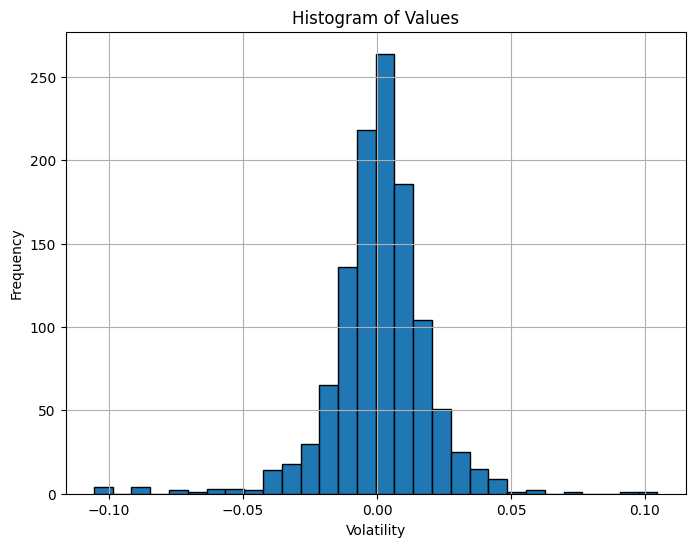

Only 2 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, sigmas, mus]


Sampling 4 chains for 10 tune and 2 draw iterations (40 + 8 draws total) took 13 seconds.
The acceptance probability does not match the target. It is 0.010702918882302534, but should be close to 0.8. Try to increase the number of tuning steps.


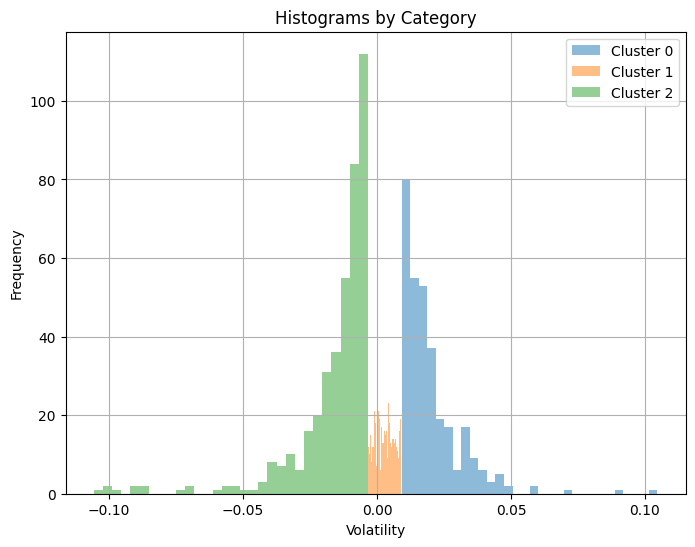

In [135]:
def assign_volatility_cluster(df, mus=[0.,0.,0.], sigmas=[.5,.5,.5]):
    """
    Assigns a volatility cluster to each value in the DataFrame.
    Give a df with a column named 'Value', this should be the volatility measure of a given window. 
    Let the index be the window or any arbitrary index.
    """
    # Plot the histogram of values
    plt.figure(figsize=(8, 6))
    plt.hist(df['moving_average'], bins=30, edgecolor='black')
    plt.xlabel('Volatility')
    plt.ylabel('Frequency')
    plt.title('Histogram of Values')
    plt.grid(True)
    plt.show()
    # Prepare the data
    values = df['moving_average'].values

    # Define the model
    with pm.Model() as model:
        # Specify the number of clusters
        k = 3
        # Priors for the cluster parameters
        mus = pm.Normal('mus', mu=0., sd=.05, shape=k)
        sigmas = pm.HalfNormal('sigmas', sd=.5, shape=k)
        weights = pm.Dirichlet('weights', a=np.ones(k))

        # Likelihood
        likelihood = pm.NormalMixture('likelihood', w=weights, mu=mus, sd=sigmas, observed=values)

        # Sample from the posterior
        trace = pm.sample(2, tune=10)
        
    cluster_means = np.array(trace['mus'][-1])
    diff = cluster_means - df['moving_average'].values[:, np.newaxis]
    cluster = np.argmin(np.abs(diff), axis=1)
    df['cluster'] = cluster


    # Separate values based on the category column
    category0_values = df[df['cluster'] == 0]['moving_average']
    category1_values = df[df['cluster'] == 1]['moving_average']
    category2_values = df[df['cluster'] == 2]['moving_average']

    # Plot the histograms
    plt.figure(figsize=(8, 6))
    plt.hist(category0_values, bins=30, alpha=0.5, label='Cluster 0')
    plt.hist(category1_values, bins=30, alpha=0.5, label='Cluster 1')
    plt.hist(category2_values, bins=30, alpha=0.5, label='Cluster 2')
    plt.xlabel('Volatility')
    plt.ylabel('Frequency')
    plt.title('Histograms by Category')
    plt.legend()
    plt.grid(True)
    plt.show()

    return df

    # Extract the cluster assignments

df_clusters = assign_volatility_cluster(df)

In [136]:
df

,returns,moving_average,cluster
Datetime,,,
2023-05-30 09:30:00-04:00,0.000000,0.000000,1
2023-05-30 09:31:00-04:00,0.005649,0.000000,1
2023-05-30 09:32:00-04:00,0.149785,0.000000,1
2023-05-30 09:33:00-04:00,0.279350,0.000000,1
2023-05-30 09:34:00-04:00,0.168835,0.000000,1
...,...,...,...
2023-06-01 15:55:00-04:00,0.100110,0.018946,0
2023-06-01 15:56:00-04:00,-0.050009,0.023947,0
2023-06-01 15:57:00-04:00,0.034300,0.017264,0


In [137]:
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder() 
df['cluster'] = label_encoder.fit_transform(df['cluster'])

In [138]:
train_cluster_names = df.cluster.unique()
train_cluster_idx = df.cluster.values

n_train_types = len(df.cluster.unique())

df[['cluster', 'returns', 'moving_average']].head()

,cluster,returns,moving_average
Datetime,,,
2023-05-30 09:30:00-04:00,1,0.000000,0.0
2023-05-30 09:31:00-04:00,1,0.005649,0.0
2023-05-30 09:32:00-04:00,1,0.149785,0.0
2023-05-30 09:33:00-04:00,1,0.279350,0.0
2023-05-30 09:34:00-04:00,1,0.168835,0.0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, β, α_tmp, β_σ, β_μ, α_σ_tmp, α_μ_tmp]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 495 seconds.
The acceptance probability does not match the target. It is 0.8396564227945701, but should be close to 0.9. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.8316004364931481, but should be close to 0.9. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated num

array([[<Axes: title={'center': 'α_μ_tmp'}>,
        <Axes: title={'center': 'α_μ_tmp'}>],
       [<Axes: title={'center': 'β_μ'}>, <Axes: title={'center': 'β_μ'}>],
       [<Axes: title={'center': 'α_σ_tmp'}>,
        <Axes: title={'center': 'α_σ_tmp'}>],
       [<Axes: title={'center': 'β_σ'}>, <Axes: title={'center': 'β_σ'}>],
       [<Axes: title={'center': 'eps'}>, <Axes: title={'center': 'eps'}>]],
      dtype=object)

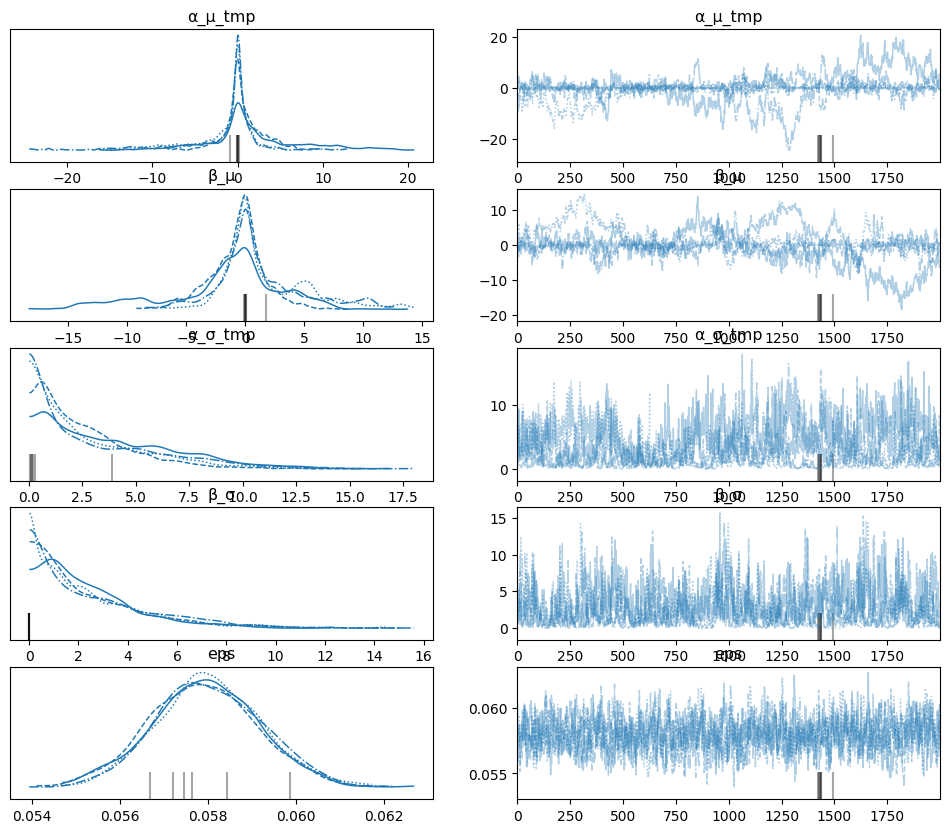

In [139]:
with pm.Model() as hierarchical_model:
    # global model parameters
    α_μ_tmp = pm.Normal('α_μ_tmp', mu=0., sd=100)
    α_σ_tmp = pm.HalfNormal('α_σ_tmp', 5.)
    β_μ = pm.Normal('β_μ', mu=0., sd=100)
    β_σ = pm.HalfNormal('β_σ', 5.)

    # train type specific model parameters
    α_tmp = pm.Normal('α_tmp', mu=α_μ_tmp, sd=α_σ_tmp, shape=n_train_types)  
    # Intercept for each train type, distributed around train type mean 
    β = pm.Normal('β', mu=β_μ, sd=β_σ, shape=n_train_types)
    # Model error
    eps = pm.HalfCauchy('eps', 5.)

    return_est = α_tmp[train_cluster_idx] + β[train_cluster_idx]*df.cluster.values

    # Data likelihood
    return_like = pm.Normal('return_like', mu=return_est, sd=eps, observed=df.returns)
    
with hierarchical_model:
    hierarchical_trace = pm.sample(2000, tune=2000, target_accept=.9)
    
pm.traceplot(hierarchical_trace, var_names=['α_μ_tmp', 'β_μ', 'α_σ_tmp', 'β_σ', 'eps'])


Got error No model on context stack. trying to find log_likelihood in translation.


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

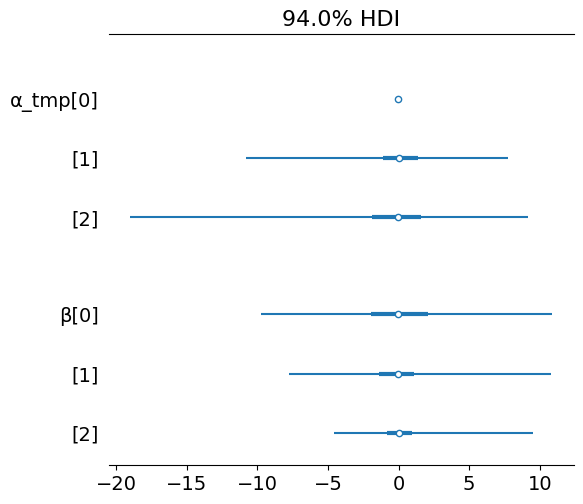

In [142]:
az.plot_forest(hierarchical_trace, var_names=['α_tmp', 'β'], combined=True)

In [143]:
ppc = pm.sample_posterior_predictive(hierarchical_trace, samples=2000, model=hierarchical_model)
az.r2_score(df.returns.values, ppc['return_like'])

r2        0.334087
r2_std    0.009237
dtype: float64